Doctors have always written clinical notes about their patients - originally, the notes were on paper and were locked away in a cabinet. Fortunately for data scientists, doctors now enter their notes in an electronic medical record. These notes represent a vast wealth of knowledge and insight that can be utilized for predictive models using Natural Language Processing (NLP) to improve patient care and hospital workflow.

This notebook is intended for people interested in healthcare data science and predictive modeling. Through this workshop, students will have the opportunity to practice
- How to prepare data for a machine learning project
- How to preprocess the unstructured notes
- How to build a simple predictive model using a bag-of-words approach
- How to assess the quality of your model
- How to decide the next step for improving the model

I recently read this great paper "Scalable and accurate deep learning for electronic health records" by Rajkomar et al. (paper at https://arxiv.org/abs/1801.07860). The authors built many state-of-the-art deep learning models with hospital data to predict in-hospital mortality (AUC = 0.93–0.94), 30-day unplanned readmission (AUC = 0.75–76), prolonged length of stay (AUC = 0.85–0.86) and discharge diagnoses (AUC = 0.90). AUC is a data science performance metric (more about this below) where closer to 1 is better. It is clear that predicting readmission is the hardest task since it has a lower AUC. I was curious how good of a model we can get if use the discharge free-text summaries with a simple predictive model.

# Model definition

Predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.

# Step 1: Prepare data set

## Load and clean dataset 

We will utilize the MIMIC-III (Medical Information Mart for Intensive Care III), an amazing free hospital database. This database contains de-identified data from over 40,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts from 2001 to 2012. In order to get access to the data for this project, you will need to request access. I prepared step-by-step instructions (https://towardsdatascience.com/getting-access-to-mimic-iii-hospital-database-for-data-science-projects-791813feb735) or you can follow the steps on the MIMIC website (https://mimic.physionet.org/gettingstarted/access/).

In this project, we will make use of the following MIMIC tables
- ADMISSIONS - a table containing admission and discharge dates (has a unique identifier HADM_ID for each admission)
- NOTEEVENTS - contains all notes for each hospitalization (links with HADM_ID)

This notebook assumes that ADMISSIONS.csv.gz and NOTEEVENTS.csv.gz were downloaded and placed in the 'data' folder which is located in the same folder as this notebook. 

Due to the restricted access, the github version of this code will not show any individual patient data. 

### Convert .gz files to csv (not needed if using artificial dataset)

Load the .gz files and save as .csv files. This will take a few minutes. 

In [1]:
import gzip

for filename in ["data/ADMISSIONS.csv.gz", "data/NOTEEVENTS.csv.gz"]:

    with gzip.open(filename, 'rt') as f:
         data = f.read()
    with open(filename[:-3], 'wt') as f:
         f.write(data)

Load, clean and merge the datasets. If you would like to walk through these steps see odsc_mimic_pre Jupyter Notebook. To save time for the workshop, we will skip over these pieces.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import odsc_utils

df_adm_notes_clean = odsc_utils.load_clean_merge_dataset('data/ADMISSIONS.csv','data/NOTEEVENTS.csv')

C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\IPython\core\interactiveshell.py:3291: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Prepare a label (not needed if using artificial dataset)

I like to create a specific column in the dataframe as OUTPUT_LABEL that has exactly what we are trying to predict. Here we want if the patient was re-admitted within 30 days

In [3]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [4]:
print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


### Create training/validation/test dataframes (not needed if using artificial dataset)

When we build a predictive model, we want the model to work well on data that the model has never seen. To test for this, we take our data and split it into three datasets: training, validation and test. 

- training set: used to train the model
- validation set: data the model didn't see, but are used to optimize or tune the model
- test set: data the model and tuning process never saw (true test of generalizability)

The validation and test set should be as close to the production data as possible. We don't want to make decisions on validation data that is not from same type of data as the test set. For example, don't use high resolution images for validation set if you think production will be amateur photos from your phone. 

In [5]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

In [6]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all)))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667):0.062
Valid prevalence(n = 7667):0.057
Train all prevalence(n = 35779):0.058
all samples (n = 51113)


In [7]:
df_train_all.to_csv('data/df_train_all.csv',index=False)
df_valid.to_csv('data/df_valid.csv',index=False)
df_test.to_csv('data/df_test.csv',index=False)

### Balance training data set

If using the artificial data set, add '_imdb' to each data file. The artificial dataset was created to have the same number of samples as the MIMIC dataset with similar number of positive and negative samples in each each of the test and validation samples. The training dataset contained the remaining data from imdb. 

In [8]:
df_test = pd.read_csv('data/df_test.csv') # 'data_artificial/df_test_imdb.csv'
df_valid = pd.read_csv('data/df_valid.csv') # 'data_artificial/df_valid_imdb.csv'
df_train_all= pd.read_csv('data/df_train_all.csv') # 'data_artificial/df_train_all_imdb.csv'

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train all prevalence(n = 35779): 0.05847005226529529


Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options
- balance the data by sub-sampling the negatives
- balance the data by over-sampling the positives
- create synthetic data (e.g. SMOTE)

In this example, we will sub-sample the negatives

In [9]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

n = np.min([len(df_train_pos),len(df_train_neg)])

# merge the balanced data
df_train = pd.concat([df_train_pos.sample(n = n, random_state = 42), \
                      df_train_neg.sample(n = n, random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4184): 0.5


In [10]:
# save csv incase you need to go back to it
df_train.to_csv('data/df_train.csv',index=False)

In [11]:
df_train = pd.read_csv('data/df_train.csv')

# Step 2: Preprocess text data

Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

BOW basically breaks up the note into the individual words and counts how many times each word occurs. Your numerical data then becomes counts for some set of words as shown below. BOW is the simplest way to do NLP classification. In most blog posts I have read, fancier techniques have a hard time beating BOW for NLP classification tasks.

In this process, there are few choices that need to be made
- how to pre-process the words
- how to count the words
- which words to use

There is no optimal choice for all NLP projects, so I recommend trying out a few options when building your own models.

You can do the pre-processing in two ways:
- modify the original dataframe TEXT column
- pre-process as part of your pipeline so you don't edit the original data (allows you try out a few options easily)

### Preprocess all the notes

Modify the original dataframe by dealing with the missing text, newlines and carriage returns

In [12]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [13]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

### Build a tokenizer

Now we need to create a function that splits the note into individual words. This function is called a tokenizer. We can use the nltk.word_tokenize function to this for us. 

In [14]:
import nltk
from nltk import word_tokenize
word_tokenize('This should be tokenized. 11/01/2018 sentence has stars**')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '11/01/2018',
 'sentence',
 'has',
 'stars**']

Note that some punctuation is separated but not all punctuation. 

We can define our own custom tokenizer. Our tokenizer will 
- replace punctuation with spaces
- remove numbers with spaces
- lowercase all words

I like to do these steps as part of the tokenizer, so I can go back and look at the original note. The new line and carriage return is more difficult to deal with so I did it in the preprocessing step above. 

In [15]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [16]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [17]:
tokenizer_better('This should be tokenized. 11/01/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

### Build a simple vectorizer

Now that we have a way to convert free-text into tokens, we need a way to create features from these tokens. 

In [18]:
sample_text = ['Open Data Science Conference is about learning', 
               'Data data DATA', 
               'Learning is part of data science']

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

In [20]:
X

<3x9 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [21]:
# we can visualize this small example if we convert it to an array
X.toarray()

array([[1, 1, 1, 1, 1, 0, 1, 0, 1],
       [0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 1]], dtype=int64)

In [22]:
# get the column names
vect.get_feature_names()

['about',
 'conference',
 'data',
 'is',
 'learning',
 'of',
 'open',
 'part',
 'science']

## build a vectorizer on the clinical notes

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x0000024915522400>,
        vocabulary=None)

# Zipf's law

Let's understand the frequency of words for each class. This section was based on code in https://www.linkedin.com/pulse/another-twitter-sentiment-analysis-python-part-2-ricky-kim/

In [24]:
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,71054,76756,147810
and,62455,71658,134113
to,53226,62085,115311
of,51303,60491,111794
was,48074,53521,101595
with,38036,44583,82619
a,35428,41629,77057
on,32290,39765,72055
mg,27718,39045,66763
in,29567,34755,64322


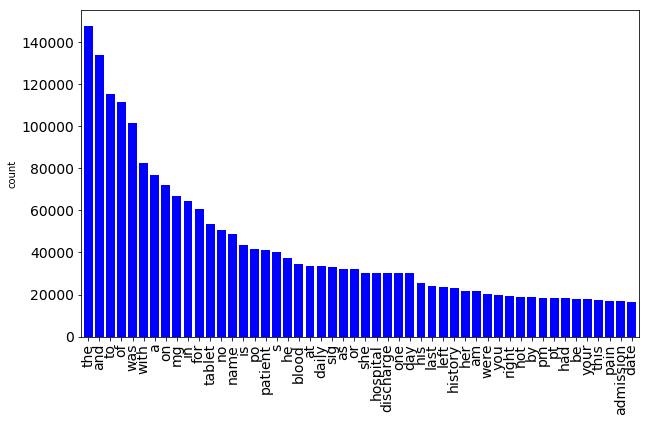

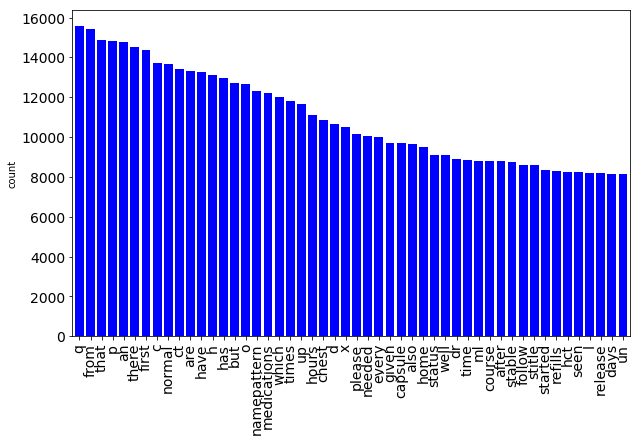

In [25]:
#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [26]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = my_stop_words)
# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x0000024915522400>,
        vocabulary=None)

Transform notes into the vector format

In [28]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

Get labels


In [29]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

# Step 3: Build a simple predictive model

Use logistic regression from scikit-learn

In [30]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Calculate probability of re-admission

In [31]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [32]:
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 0 1 1 1 0 0 1 1]
[0.76307111 0.63114288 0.29772094 0.77926068 0.59694889 0.55643044
 0.36292154 0.90984735 0.47806099 0.67622763]


# Step 4. Calculate Performance Metrics

In data science, there are many performance metrics. If you would like to read more about them see my article at https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

<img src="img/perf_metrics.png">

In [33]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)


Train prevalence:0.500
Valid prevalence:0.057
Train AUC:0.757
Valid AUC:0.704
Train accuracy:0.695
Valid accuracy:0.682
Train recall:0.666
Valid recall:0.648
Train precision:0.706
Valid precision:0.110
Train specificity:0.723
Valid specificity:0.684


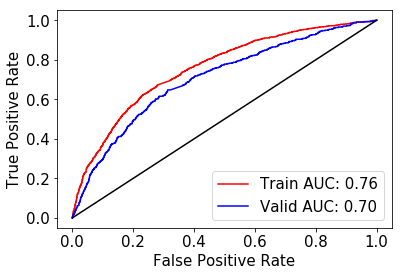

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%accuracy_score(y_train, y_train_preds >= thresh))
print('Valid accuracy:%.3f'%accuracy_score(y_valid, y_valid_preds >= thresh))

print('Train recall:%.3f'%recall_score(y_train, y_train_preds>= thresh))
print('Valid recall:%.3f'%recall_score(y_valid, y_valid_preds>= thresh))

print('Train precision:%.3f'%precision_score(y_train, y_train_preds>= thresh))
print('Valid precision:%.3f'%precision_score(y_valid, y_valid_preds>= thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Step 5. Try to improve the model

At this point, you might be tempted to calculate the performance on your test set and see how you did. But wait! We made many choices  (a few below) which we could change and see if there is an effect:
- which and how much data to use - should we spend time getting more data?
- how to tokenize - should we use something called stemming too? 
- how to vectorizer - should we change the number of words?
- how to regularized the logistic regression - should we change C or penalty?
- which model to use?

When we want to improve the model, we want to do it in a data-driven manner (if we can). 

You can spend a lot of time on 'hunches', that don't end up panning out. 

There are a few techniques that will help us get big insight.  

## Create a learning curve
Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [35]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

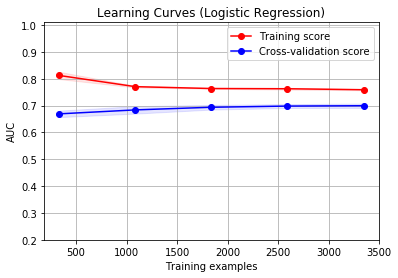

In [36]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')#
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

# Feature Importance

Let's look at the most important tokens for each class. 

In [37]:
feature_importances = pd.DataFrame(clf.coef_[0],
                                   index = vect.get_feature_names(),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

For logistic regression, the variables with highest positive coefficients are predictive of re-hospitalization and the variables with highest negative coefficients are predictive of not being re-hospitalized. We can plot the top 50 for each direction below. 

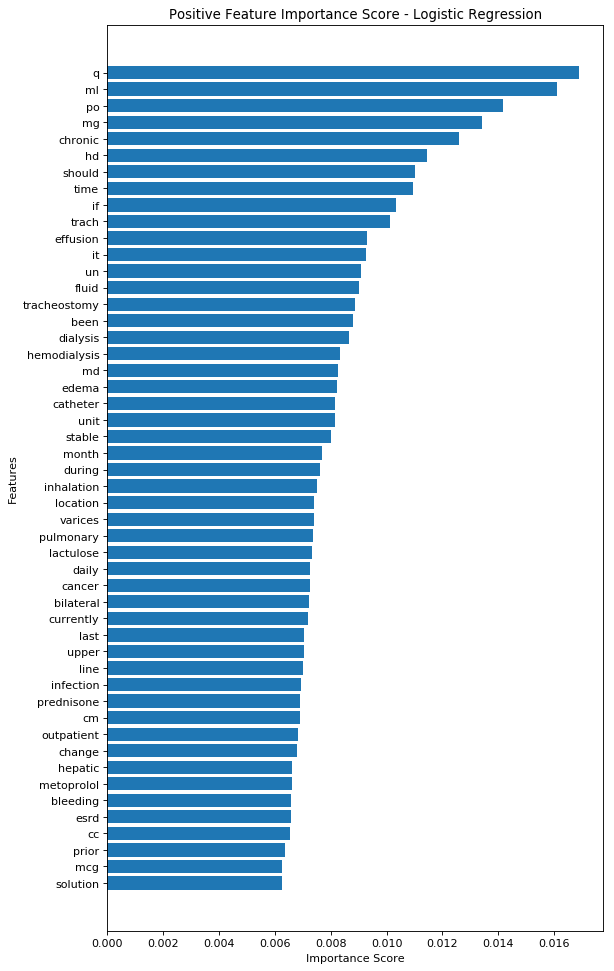

In [38]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

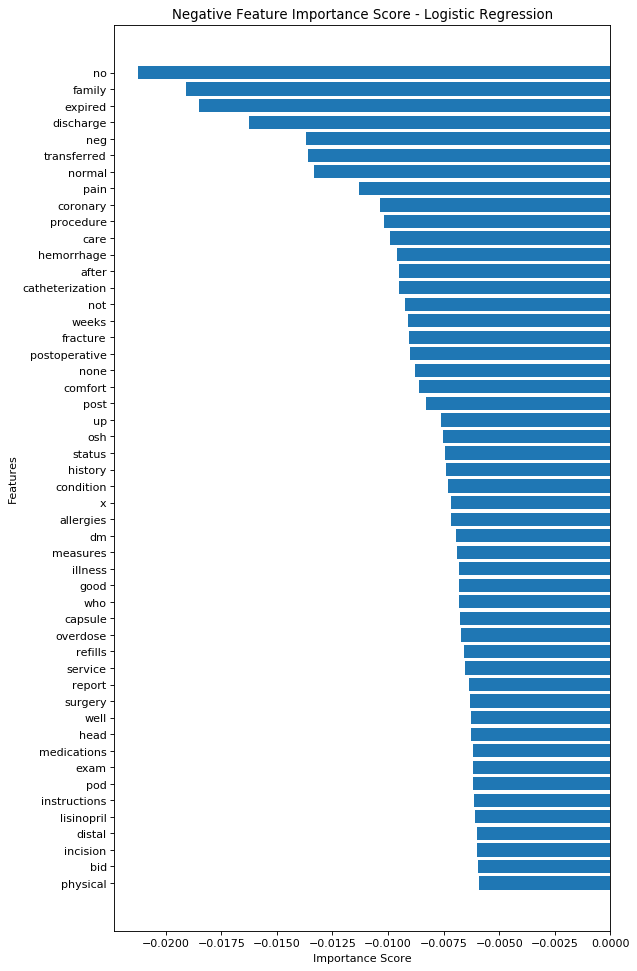

In [39]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

### update stop words

In [40]:
my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

In [41]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenizer_better,stop_words =my_new_stop_words)
#
# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

## Hyperparameter Tuning

You can run a grid-search if you want to select the best option out of all your parameters, but for this workshop we will just visually look at them. 

### Investigate effect of C

In [42]:
from sklearn.linear_model import LogisticRegression

Cs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid


 C: 1e-05


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.700
Valid AUC:0.680

 C: 3e-05


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.723
Valid AUC:0.691

 C: 0.0001


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.755
Valid AUC:0.705

 C: 0.0003


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.796
Valid AUC:0.715

 C: 0.001


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.853
Valid AUC:0.718

 C: 0.003


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.904
Valid AUC:0.705


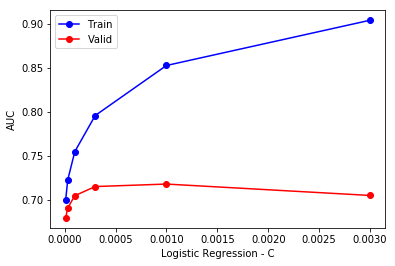

In [43]:
plt.plot(Cs, train_aucs,'bo-', label ='Train')
plt.plot(Cs, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Logistic Regression - C')
plt.ylabel('AUC')
plt.show()

### Investigate effect of max_features (takes a long time)

In [44]:
num_features = [100,300,1000,3000,10000,30000]
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))

for ii in range(len(num_features)):
    num = num_features[ii]
    print('\nnumber of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, 
                           tokenizer = tokenizer_better,stop_words =my_new_stop_words)

    # This could take a while
    vect.fit(df_train.TEXT.values)

    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    y_train = df_train.OUTPUT_LABEL
    y_valid = df_valid.OUTPUT_LABEL
    
    clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC: %.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid


number of features: 100


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.686
Valid AUC:0.666

number of features: 300


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.714
Valid AUC:0.683

number of features: 1000


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.738
Valid AUC:0.698

number of features: 3000


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.755
Valid AUC:0.705

number of features: 10000


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.761
Valid AUC:0.706

number of features: 30000


C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.762
Valid AUC:0.706


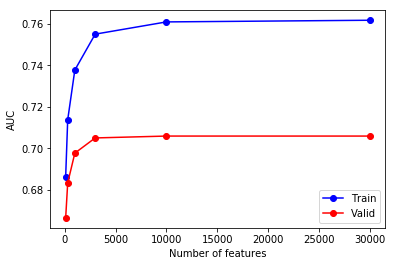

In [45]:
plt.plot(num_features, train_aucs,'bo-', label ='Train')
plt.plot(num_features, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.show()

# Final model without death

In [46]:
# shuffle the samples

rows_not_death = df_adm_notes_clean.DEATHTIME.isnull()

df_adm_notes_not_death = df_adm_notes_clean.loc[rows_not_death].copy()
df_adm_notes_not_death = df_adm_notes_not_death.sample(n = len(df_adm_notes_not_death), random_state = 42)
df_adm_notes_not_death = df_adm_notes_not_death.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_not_death.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_not_death.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_not_death) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)


Test prevalence(n = 6798): 0.06590173580464842
Valid prevalence(n = 6798): 0.06913798175934098
Train all prevalence(n = 31725): 0.0644602048857368
all samples (n = 51113)
Train prevalence (n = 4090): 0.5


In [47]:
my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(lowercase = True, max_features = 3000, 
                       tokenizer = tokenizer_better,
                      stop_words = my_new_stop_words)

# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]

C:\Users\Andy\AppData\Local\conda\conda\envs\odsc_workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train prevalence:0.500
Valid prevalence:0.069
Test prevalence: 0.066
Train AUC:0.745
Valid AUC:0.709
Test AUC:0.704
Train accuracy:0.683
Valid accuracy:0.672
Test accuracy:0.681
Train recall:0.644
Valid recall:0.651
Test recall:0.607
Train precision:0.698
Valid precision:0.129
Test precision:0.120
Train specificity:0.722
Valid specificity:0.674
Test specificity:0.686


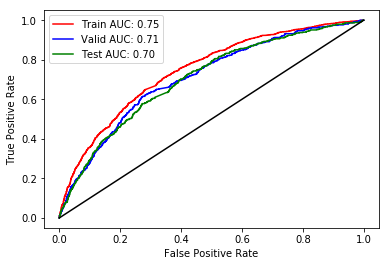

In [48]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))
print('Test prevalence: %.3f'%calc_prevalence(y_test))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%accuracy_score(y_train, y_train_preds >= thresh))
print('Valid accuracy:%.3f'%accuracy_score(y_valid, y_valid_preds >= thresh))
print('Test accuracy:%.3f'%accuracy_score(y_test, y_test_preds>= thresh))

print('Train recall:%.3f'%recall_score(y_train, y_train_preds>= thresh))
print('Valid recall:%.3f'%recall_score(y_valid, y_valid_preds>= thresh))
print('Test recall:%.3f'%recall_score(y_test, y_test_preds>= thresh))

print('Train precision:%.3f'%precision_score(y_train, y_train_preds>= thresh))
print('Valid precision:%.3f'%precision_score(y_valid, y_valid_preds>= thresh))
print('Test precision:%.3f'%precision_score(y_test, y_test_preds>= thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()